In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import copy
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(7395, 23)
(7395, 1)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM_acceleration[:, -2] == 1)[0]
X_motion_CoM_acceleration_FL_RR = X_motion_CoM_acceleration[idx_fl_rr_swinging]
Y_motion_CoM_acceleration_FL_RR = Y_motion_CoM_acceleration[idx_fl_rr_swinging]

In [8]:
idx_fl_rr_swinging.shape

(3698,)

## Predict CoM -> x

In [9]:
X_motion_CoM_acceleration_FL_RR[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.08211927296688538,
       -0.006190249900498238, 0.004897310096421506, 0.23448798276244606,
       0.12098631919533982, -0.3137060426867018, 0.26968373256762473,
       -0.13223646069879796, -0.26779937819670413, -0.2529431561992731,
       0.137068249222371, -0.271737754407289, -0.2829489817038638,
       -0.12839868699316448, -0.31333760531450466, True, False],
      dtype=object)

In [10]:
Y_motion_CoM_acceleration_FL_RR[0, :]

array([0.08361987936659881], dtype=object)

### Linear Regression

In [11]:
def find_best_model(X, Y, runs=5000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [12]:
X_motion_CoM_acceleration_FL_RR[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.08211927296688538,
       -0.006190249900498238, 0.004897310096421506, 0.23448798276244606,
       0.12098631919533982, -0.3137060426867018, 0.26968373256762473,
       -0.13223646069879796, -0.26779937819670413, -0.2529431561992731,
       0.137068249222371, -0.271737754407289, -0.2829489817038638,
       -0.12839868699316448, -0.31333760531450466, True, False],
      dtype=object)

In [13]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FL_RR[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FL_RR[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FL_RR[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FL_RR[:, 9:11], # FL position
               X_motion_CoM_acceleration_FL_RR[:, 12:14], # FR position
               X_motion_CoM_acceleration_FL_RR[:, 15:17], # RL position
               X_motion_CoM_acceleration_FL_RR[:, 18:20])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_com_x = find_best_model(X, Y, runs=5000)

R2:  0.997537689186769
RMSE:  0.015421832556424549
The lowest error is:  2.3644486136398246e-05
The highest error is:  0.04883672529833294
The avg. error is:  0.01196440569021886


In [14]:
model_fl_com_x.coef_

array([[ 1.51311819e-01,  8.68534790e-01,  2.00566276e-04,
        -3.04400739e-01,  7.75761059e-01, -3.09623448e-01,
        -3.91335369e-01, -2.02461351e-02, -3.69572434e-01,
         2.87805731e-01,  7.84373735e-02]])

In [15]:
model_fl_com_x.intercept_

array([0.12874086])

Text(0, 0.5, 'Predictions')

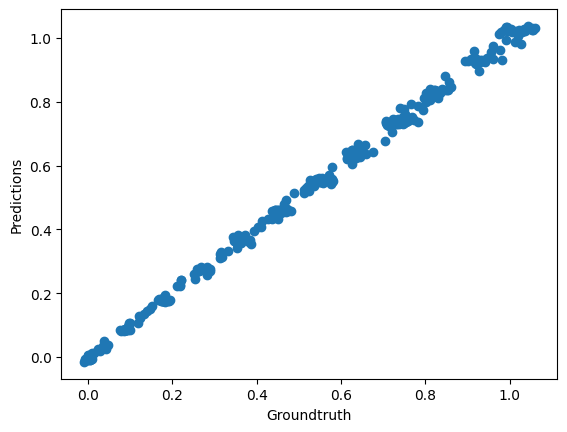

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx][0]}. Predicted: {prediction[0]}. Error: {np.abs(np.round(Y_test[idx][0]-prediction[0],3))}.')

## Predict FL foot -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FL_RR[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FL_RR[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FL_RR[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FL_RR[:, 9:11], # FL position
               X_motion_CoM_acceleration_FL_RR[:, 12:14], # FR position
               X_motion_CoM_acceleration_FL_RR[:, 15:17], # RL position
               X_motion_CoM_acceleration_FL_RR[:, 18:20])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FL_RR[:, 1]]).T

# Train data

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_com_y = find_best_model(X, Y, runs=5000)

R2:  0.9451522053242764
RMSE:  0.0012365816220829338
The lowest error is:  7.721081019417713e-06
The highest error is:  0.00347943117230048
The avg. error is:  0.0009399662045315716


In [19]:
model_fl_com_y.coef_

array([[ 0.07368683, -0.0190597 , -0.06999727,  0.02913666, -0.04015361,
         0.02637025,  0.0770786 ,  0.00990728, -0.0413788 , -0.03701894,
         0.03541562]])

In [20]:
model_fl_com_y.intercept_

array([0.00271257])

Text(0, 0.5, 'Predictions')

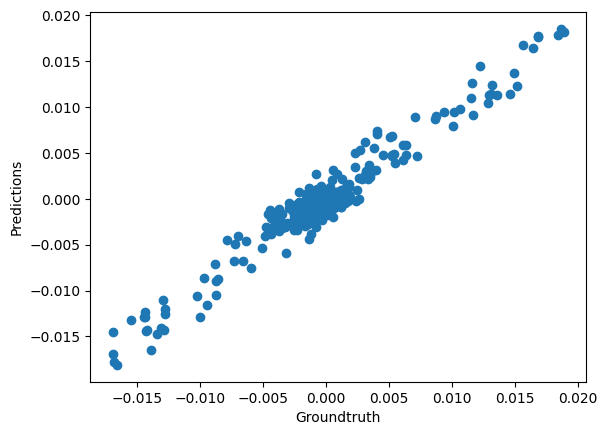

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')